## 1. Combinatorial Optimization on Analog Neutral-Atom Quantum Computers

### 1.1 The Neutral-atom Hamiltonian

For an array of $N$ neutral atoms restricted to the two levels $\ket{g}$ (ground) and $\ket{r}$ (Rydberg) the dynamics are described by

$$
\boxed{%
H(t)=
\frac{\Omega(t)}{2}\sum_{i=1}^{N}\bigl(\ket{g}_i\!\bra{r}+\ket{r}_i\!\bra{g}\bigr)
-\Delta(t)\sum_{i=1}^{N}\hat n_i
+\sum_{i<j}V_{ij}\hat n_i\hat n_j
}\tag{1}
$$

where

* $\Omega(t)$ is a uniform Rabi frequency applied to all atoms,
* $\hat n_i=\ket{r}_i\!\bra{r}$ projects atom $i$ onto $\ket{r}$,
* $\Delta(t)$ is a global detuning,
* $V_{ij}=C_6/r_{ij}^{6}$ is the van-der-Waals interaction between excited atoms $i$ and $j$ separated by $r_{ij}$.

**Note:** Aquila supports site-dependent detuning weights $w_i \in (0, 1)$ that locally scale $\Delta(t)$, but this is beyond the scope of this notebook.

### 1.2 Bloqade-Analog

In this notebook we will be simulating analog quantum programs using [Bloqade-Analog](https://github.com/QuEraComputing/bloqade-analog), "an SDK designed to make writing and analyzing the results of analog quantum programs on QuEra's neutral atom quantum computers as seamless and flexible as possible".

### 1.2 Rydberg blockade

Entanglement is a resource that elevates quantum computers beyond classical computing capabilities. Once qubits are entangled, measuring one immediately constrains the outcomes of the others. Combining entanglement with superposition allows quantum algorithms to compute exponentially many computational pathways in quantum-parallel.

Analog neutral-atom quantum computing generates entanglement via the **Rydberg blockade**. Because two atoms simultaneously driven towards $\ket{r}$ shift each other’s energy by the interaction $C_6/r^{6}$, if their separation is below the **blockade radius** $r_b$ this energy-shift move the doubly excited state off resonance. Consequently at most one atom can be excited.

#### A Note on Conversions

In `bloqade` we assign a logical "0"‐bit to $\ket{r}$ (the excited Rydberg state) and a “1”‐bit to $\ket{g}$ (the ground state). This reflects the read-out operation on the neutral atom array. After the computation pulses complete, the trapping lasers are briefly turned off (or detuned) so the Rydberg atoms become anti‑trapped and are ejected by a resonant laser pulse, and the final fluorescence imaging then detects the remaining ground‑state atoms.

Simply put, “0” denotes the *absence* of an atom that was in the $\ket{r}$ state, while “1” denotes the *presence* of an atom that was in the $\ket{g}$ state prior to measurement.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from bloqade.analog.atom_arrangement import Chain

program = Chain(2, lattice_spacing = 'lattice_spacing').rydberg.rabi.amplitude.uniform.piecewise_linear(durations = [0.05,  0.15, 0.05], values = [0, 15.8, 15.8, 0])

program_assigned = program.assign(lattice_spacing = 5.5)
job = program_assigned.bloqade.python().run(shots=100)    

#job.report().show()

job.report().counts()

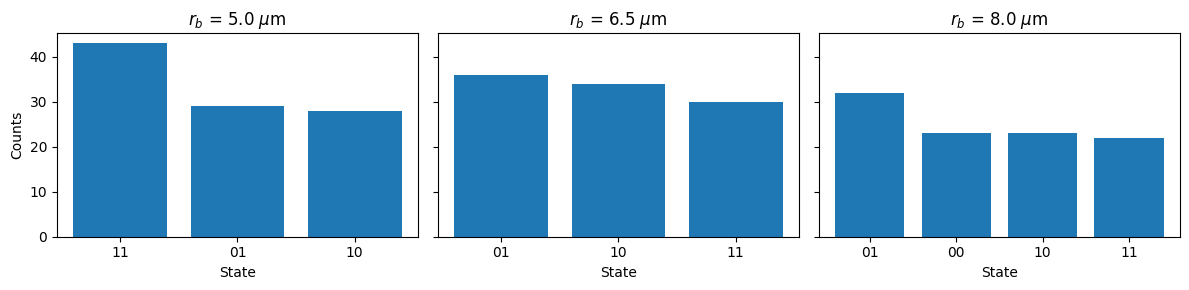

In [10]:
shots = 100
rbs   = np.linspace(5.0, 8.0, 3)          # blockade radii

fig, axes = plt.subplots(1, len(rbs), figsize=(12, 3), sharey=True)

for ax, rb in zip(axes, rbs):
    program_assigned = program.assign(lattice_spacing=rb)
    job    = program_assigned.bloqade.python().run(shots=shots)
    counts = job.report().counts()[0]

    labels, values = zip(*counts.items())

    ax.bar(labels, values)
    ax.set_xlabel("State")
    ax.set_title(r"$r_b$ = " + str(np.round(rb,2)) + r" $\mu \text{m}$")

axes[0].set_ylabel("Counts")
fig.tight_layout()
plt.show()


### 1.3 Maximum Independent Set embeddings

The **Maximum Independent Set** (MIS) problem asks for the largest set $S\subseteq V(G)$ in which no two vertices share an edge. Classical exact algorithms scale exponentially in the worst case.

Aquila’s reconfigurable two-dimensional atom array offers a direct physical encoding. Each vertex becomes an atom; atoms representing adjacent vertices are placed within $r_b$, so the blockade enforces the “non-adjacent” constraint: exciting both would be forbidden. By programming suitable global Rabi and detuning pulses one steers the system from the initial state $\ket{g_1 g_2 \dots g_N}$ toward Rydberg configurations that correspond to maximal independent sets. Because any NP-hard optimisation task can be reduced to MIS with at most polynomial overhead, this mapping lets Aquila tackle a broad class of hard problems within this blockade-based Hamiltonian framework.

![Graph showing how the blockade effect can encode MIS.](figures/MIS_diagram.png)

**Left**: A unit-disk graph, edges are created between nodes that are closer to each other than a certain fixed distance on the 2D plane. **Right**: Red nodes mark a MIS of the graph corresponding to the largest number of nodes (six) that are not directly connected. ([Ebadi et al., Science (2022)](https://arxiv.org/abs/2202.09372), [AWS Quantum Technologies Blog](https://aws.amazon.com/blogs/quantum-computing/optimization-with-rydberg-atom-based-quantum-processor/))

## 2. Solving the Max-2-SAT Problem

Max-2-SAT is an optimisation variant of the classic satisfiability problem. We have a set of Boolean clauses written in *conjunctive normal form*, meaning every clause is an OR ($\lor$) of two literals—either an unnegated variable $x_i$ or its negation $\lnot x_i$. For example

$$
(x_1 \lor  x_2), \qquad
(\lnot x_1 \lor x_2), \qquad
(x_1 \lor \lnot x_2), \qquad
(\lnot x_1 \lor \lnot x_2).
$$

The task is to assign truth values to the variables so that the maximum number of clauses evaluate to **true**.  Formally, for $m$ clauses $C_1,\dots,C_m$ over variables $x_1,\dots,x_n$ we look for $\mathbf{x}\in\{0,1\}^n$ that maximises

$$
\sum_{k=1}^{m}\bigl[C_k(\mathbf{x})\bigr],
$$

where $[\,\cdot\,]$ is $1$ if the clause is satisfied and $0$ otherwise.

#### Why is it interesting?

* Benchmark for classical approximation algorithms.
* Canonical NP-hard problem that appears as a gadget in many reductions.
* Natural starting point for quantum optimisation because every clause maps to a local two-body term in a Hamiltonian.

### 2.1 Building the conflict graph

To recast a Max-2-SAT instance as a **Maximum Independent Set** (MIS) problem we first build a *conflict graph*.

* For each clause we add two vertices, one per literal, and connect them with a **clause edge** so at most one can be chosen (only one literal needs to be true to satisfy the clause).
* For each variable $x_i$ we connect every vertex labelled $x_i$ to every vertex labelled $\lnot x_i$ with a **variable edge**; choosing both would create a logical contradiction.

The resulting graph has $2m$ vertices and a polynomial number of edges.  A maximum independent set in this graph corresponds one-to-one with an assignment that satisfies the maximum possible number of clauses.

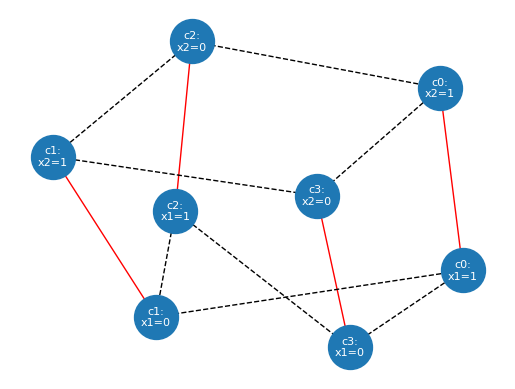

In [11]:
from workshop_utils import generate_mis_graph_from_2sat, visualize_graph

clauses = [
    (1,  2),
    (-1, 2),
    (1, -2),
    (-1,-2)
]

G = generate_mis_graph_from_2sat(clauses)

visualize_graph(G) # red edges indicate a clauses, dashed edges a conflict


### 5.2 From abstract graph to physical layout

To embed the conflict graph on an analogue neutral-atom processor such as **QuEra Aquila** we exploit the **Rydberg blockade**: once an atom is excited to $\ket{r}$, any atom within a distance $r_b$ is off-resonant and cannot be excited simultaneously.

Our goal is therefore:

* atoms representing **non-adjacent** vertices must be **farther** than $r_b$ apart,
* atoms representing **adjacent** vertices must be **within** $r_b$ to enforce the blockade constraint.

We seed positions with NetworkX’s spring layout (a force-directed algorithm) to obtain a well-spread initial geometry, flatten the coordinates into a length-$2|V|$ vector, and refine them with a continuous optimiser that enforces the blockade constraints.  The optimised coordinates are then passed to `bloqade.start.add_position` to define the tweezer array on which we construct the optimisation programme.

In [12]:
import networkx as nx
from scipy.optimize import minimize
from workshop_utils import layout_objective 

from bloqade.analog import start

# get initial positions from a networkx spring layout
initial_pos = nx.spring_layout(G, seed=42, dim=2, k = 2)
node_list = list(G.nodes)
index_map = {node: i for i, node in enumerate(node_list)}
positions_array = np.array([initial_pos[node] for node in node_list])
x0 = positions_array.flatten()

r_b = 6.5 # blockade radius
r_min = 6.0 # minimum distance

res = minimize(layout_objective, x0, args=(G, r_b, r_min), method='BFGS')
final_positions = res.x.reshape(-1, 2)
scaled_pos_dict = {node: final_positions[i] for i, node in enumerate(node_list)}

positions = np.array(list(scaled_pos_dict.values()))
geometry = start.add_position(positions)  
print(geometry)

                                   Atom Positions                               
    ┌──────────────────────────────────────────────────────────────────────────┐
 5.1┤                                                       •                  │
    │                            •                                             │
    │                                                                          │
 3.2┤•                                                                         │
    │                                                                          │
    │                                                                          │
 1.3┤                                                                          │
    │                                                                         •│
    │                                                                          │
-0.6┤                                            •                             │
    │                 •     

### 5.3 The Cost-Function

To find optimal or near-optimal solutions to the problem we minimise the average of the measured MIS costs,
$$
\texttt{MIS\_Cost(bitstr, G)} = -\sum_{(i,j)\in E}\!\bigl[b_i\neq b_j\bigr]
$$
where $E$ is the set of edges connecting the vertices in the conflict graph $G$.


In [13]:
def MIS_Cost(bitstr: str, G: nx.Graph) -> int:
    """
    Cost of one measured solution-bitstring
    """
    cost = 0
    for edge in G.edges():
        if bitstr[edge[0]] != bitstr[edge[1]]:
            cost += 1
    return -cost

def expectation(counts: dict, G: nx.Graph) -> float:
    """
    Expectation value (mean) cost of `total_shots`.
    """

    total_shots = sum(counts.values())

    total_cost = 0.0
    for bitstr, cnt in counts.items():
        cost = MIS_Cost(bitstr, G)
        total_cost += cost * cnt

    return total_cost / total_shots

## 5. Design the Pulse Protocols

### 5.1 Adiabatic Quantum Computing (AQC)

The idea is to initialise the atoms in an easy-to-prepare state and then vary the Hamiltonian slowly enough that the system tracks its instantaneous ground state, ending in a configuration that encodes a maximum independent set.

We implement this with linear ramps in the global Rabi drive and global detuning
$$
\Omega(t)=\Omega_{\max}\!\left(1-\frac{t}{T}\right),\qquad
\Delta(t)=\Delta_{\max}\!\left(\frac{t}{T}\right),
$$
where $T$ is the total anneal time.

* **Start, $t_0 = 0$.**
The drive is at its maximum $\Omega_{\max}=15.8 \text{MHz}$ and the detuning is $\Delta(0)=0$. So:
$$
H(0)=\frac{\Omega_{\max}}{2}\sum_{i=1}^{N}\bigl(\ket{g}_i\!\bra{r}+\ket{r}_i\!\bra{g}\bigr) +\sum_{i<j}V_{ij}\hat n_i\hat n_j.
$$
Because $\Omega_{\max}$ dominates and the interaction term penalises simultaneous excitations, the system starts close to the product state $\ket{g_1g_2\dots g_N}$.

* **End, $t_1=T$.**
The Rabi drive is fully switched off, $\Omega(T)=0$, while the detuning has reached $\Delta_{\max}=125 \text{MHz}$:
$$
H(T)=\sum_{i<j}V_{ij}\hat n_i\hat n_j-\Delta_{\max}\sum_{i=1}^{N}\hat n_i.
$$
Thus the Hamiltonian favours configurations with more excitations - the maximal independent sets of the embedded graph.

If ramping is sufficiently gradual, the system remains near the ground state, giving a high probability of measuring an optimal (or near-optimal) solution at the end.

For additional background see [*comparing the Hardness of Max 2-SAT Problem Instances for Quantum and Classical Algorithms* (YouTube)](https://www.youtube.com/watch?v=sNkCVf09glc).


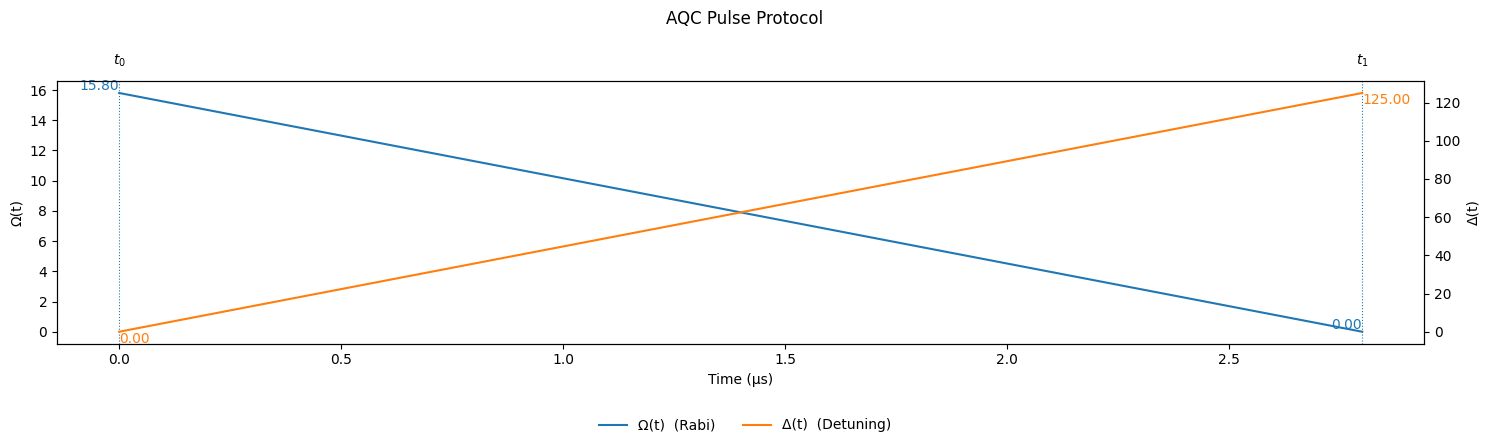

In [14]:
from workshop_utils import visualise_pulses

rabi_durations      = [f"rabi_t{i}"      for i in range(1, 2)] 
rabi_amplitudes     = [f"omega{i}"  for i in range(1, 3)]   
detuning_durations  = [f"delta_t{i}"      for i in range(1, 2)]  
detuning_amplitudes = [f"delta{i}"  for i in range(1, 3)]   


prog_args = rabi_durations + rabi_amplitudes + detuning_durations + detuning_amplitudes

prog = geometry  
prog = prog.rydberg.rabi.amplitude.uniform.piecewise_linear(durations=rabi_durations, values=rabi_amplitudes)
prog = prog.rydberg.detuning.uniform.piecewise_linear(durations=detuning_durations, values=detuning_amplitudes)

prog = prog.args(prog_args)               

def map_parameters(x):

    T = x[0]   

    Omega_max = 15.8   
    Delta_max = 125      

    rts = [T]
    dts = [T]   

    ras = [Omega_max, 0]      
    das = [0, Delta_max] 

    return rts, ras, dts, das

t_1 = 2.8
visualise_pulses(*map_parameters([t_1]), title = "AQC Pulse Protocol")

Optimal time = 1.8888888888888888


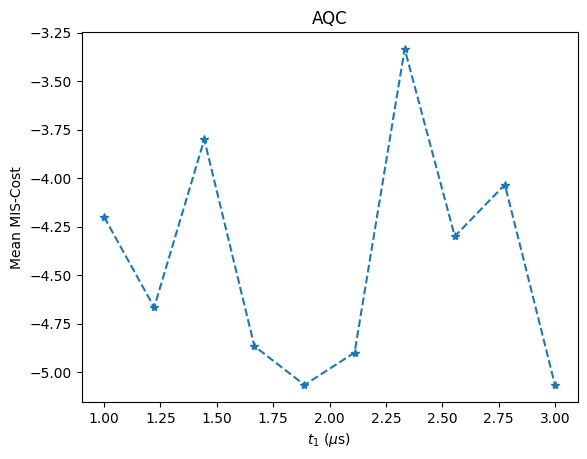

In [27]:
def objective(x,  prog, shots):
    rts, ras, dts, das = map_parameters(x)
    result = prog.bloqade.python().run(shots=shots, args = tuple(rts + ras + dts + das), blockade_radius = r_b)
    cost = expectation(result.report().counts()[0], G)
    return cost

ts = np.linspace(1, 3, 10)
obs = []
for t in ts:
    obs.append(objective([t], prog, shots = 30))

opt_t = ts[np.argmin(obs)]

print('Optimal time =', opt_t)

plt.plot(ts, obs, '--*')
plt.ylabel('Mean MIS-Cost')
plt.xlabel(r'$t_1$ ($\mu \rm{s}$)')
plt.title('AQC')

plt.show()

In [22]:
from workshop_utils import pretty_print_clauses

rts, ras, dts, das = map_parameters([opt_t])
job = prog.bloqade.python().run(shots=10000, args = tuple(rts + ras + dts + das))
print(job.report().counts()) # Counts by bitstring
for solution in list(job.report().counts()[0].keys())[:2]:
    print(f'\nSolution: {solution}')
    pretty_print_clauses(clauses, solution)

[OrderedDict([('11011011', 1555), ('11001101', 1468), ('01110101', 1043), ('11110010', 879), ('11101110', 701), ('11111111', 434), ('11111010', 426), ('11110110', 372), ('11110101', 346), ('10111111', 337), ('00111111', 256), ('11110111', 243), ('11111101', 242), ('11111011', 234), ('11011101', 227), ('11001111', 202), ('01111111', 193), ('11101111', 163), ('11110011', 160), ('11011111', 127), ('01110110', 94), ('01111101', 77), ('11101101', 72), ('01011101', 46), ('01011111', 33), ('11111110', 29), ('01111110', 19), ('01110111', 5), ('11111100', 4), ('01110100', 3), ('10111101', 3), ('10111110', 2), ('00011111', 1), ('01010101', 1), ('01111100', 1), ('11001100', 1), ('11010110', 1)])]

Solution: 11011011
Variable assignment:
  x1 = False
  x2 = False

Clause 1: (x1 ∨ x2) -> unsatisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: (x1 ∨ ¬x2) -> satisfied
Clause 4: (¬x1 ∨ ¬x2) -> satisfied

Solution: 11001101
Variable assignment:
  x1 = False
  x2 = True

Clause 1: (x1 ∨ x2) -> satisfied

### 5.2 Quantum-walk-based Ansatz.

Here we adopt an ansatz patterned on the alternating-unitary structure of **Grover’s search**-or, equivalently, the first layer of the **Quantum Approximate Optimisation Algorithm** (QAOA).


1. **Prepare:** A short Rabi pulse supplies an area of $\pi/2$, creating an approximately uniform superposition inside the Rydberg-blockaded subspace.
2. **Phase mark:** Global detuning is applied for a pulse area of $\pi/N$. Each basis state acquires a phase proportional to its number of excited states.
3. **Interfere:** A second Rabi pulse with tunable pulse area $\tfrac{(t_8 + 0.1)\Omega}{2}$ leverages those phase differences to produce constructive interference at states encoding optimal or near-optimal MIS solutions.

All three pulses share the same trapezoid profile with $0.05\,\mu\text{s}$ linear ramps either-side of a constant plateau.

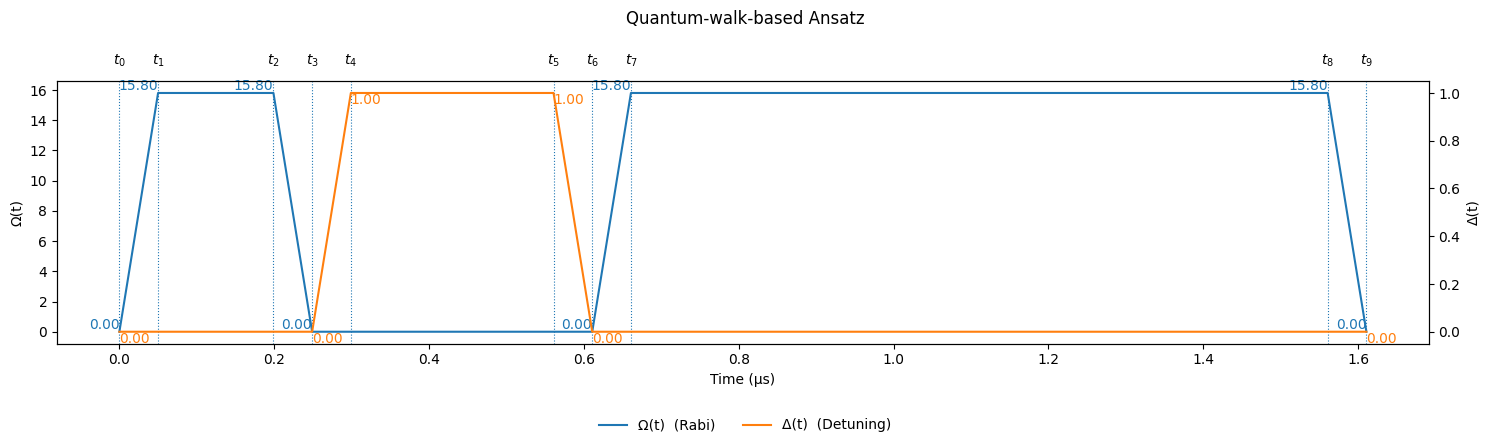

In [26]:
rabi_durations = [f"t{i}" for i in range(1, 8)]
rabi_amplitudes = [f"omega{i}" for  i in range(1, 9)]
detuning_durations = [f"t{i}" for i in range(8, 13)]
detuning_amplitudes = [f"delta{i}" for i in range(1, 7)]

prog_args = rabi_durations + rabi_amplitudes + detuning_durations + detuning_amplitudes

prog = geometry
prog = prog.rydberg.rabi.amplitude.uniform.piecewise_linear(durations = rabi_durations, values = rabi_amplitudes)
prog = prog.rydberg.detuning.uniform.piecewise_linear(durations = detuning_durations, values = detuning_amplitudes)

prog = prog.args(prog_args)

def map_parameters(x):
    t2 = 0.149 # Pulse duration for a pi/2 pulse with an amplitude of 15.8.
    t6 = x[0]
    t10 = np.pi/12
    rts = [0.05, t2, 0.05, 0.1 + t10, 0.05, t6, 0.05]
    ras = [0, 15.8,  15.8, 0, 0, 15.8, 15.8, 0]
    dts = [0.1 + t2,  0.05, t10, 0.05, 0.1 + t6]
    das = [0,  0, 1, 1, 0, 0]
    return rts, ras, dts, das

t_8 = 0.9
visualise_pulses(*map_parameters([t_8]), title = "Quantum-walk-based Ansatz")

Optimal time = 0.9


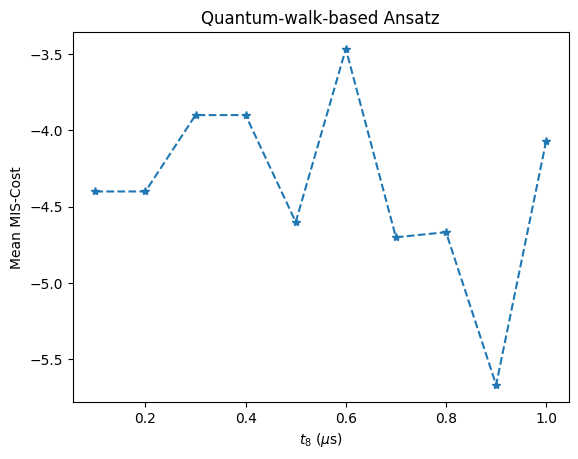

In [24]:
def objective(x,  prog, shots):
    rts, ras, dts, das = map_parameters(x)
    result = prog.bloqade.python().run(shots=shots, args = tuple(rts + ras + dts + das), blockade_radius = r_b)
    cost = expectation(result.report().counts()[0], G)
    return cost

ts = np.linspace(0.1, 1.0, 10)
obs = []
for t in ts:
    obs.append(objective([t], prog, shots = 30))

opt_t = ts[np.argmin(obs)]

print('Optimal time =', opt_t)

plt.plot(ts, obs, '--*')
plt.ylabel('Mean MIS-Cost')
plt.xlabel(r'$t_8$ ($\mu \rm{s}$)')
plt.title('Quantum-walk-based Ansatz')

plt.show()

In [25]:
rts, ras, dts, das = map_parameters([opt_t])
job = prog.bloqade.python().run(shots=10000, args = tuple(rts + ras + dts + das))
print(job.report().counts()) # Counts by bitstring

for solution in list(job.report().counts()[0].keys())[:2]:
    print(f'\nSolution: {solution}')
    pretty_print_clauses(clauses, solution)

[OrderedDict([('11001101', 1592), ('00111111', 1403), ('01111101', 1069), ('11110010', 1021), ('01110111', 942), ('01011111', 677), ('11110011', 425), ('11101101', 387), ('11101111', 353), ('11110111', 291), ('10111111', 264), ('01110101', 224), ('01111111', 168), ('01110110', 142), ('01111110', 124), ('11011101', 113), ('11110101', 113), ('11110110', 89), ('11111111', 89), ('11011111', 88), ('11111101', 87), ('11101110', 67), ('11111011', 61), ('01011101', 52), ('11111010', 52), ('11011011', 48), ('11001111', 38), ('11111110', 14), ('11011110', 2), ('01101101', 1), ('01111100', 1), ('10101111', 1), ('11100111', 1), ('11110100', 1)])]

Solution: 11001101
Variable assignment:
  x1 = False
  x2 = True

Clause 1: (x1 ∨ x2) -> satisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: (x1 ∨ ¬x2) -> unsatisfied
Clause 4: (¬x1 ∨ ¬x2) -> satisfied

Solution: 00111111
Variable assignment:
  x1 = True
  x2 = True

Clause 1: (x1 ∨ x2) -> satisfied
Clause 2: (¬x1 ∨ x2) -> satisfied
Clause 3: (x1 ∨ ¬x2